In [1]:
import sys
import IPython.display

In [2]:
sys.path.insert(0, "/home/mai/zkhan/ALBEF")

In [816]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

In [4]:
from models.tokenization_bert import BertTokenizer
from models.single_stream_pretrain import ALBEF

In [393]:
import json
import random
import ruamel.yaml as yaml
from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
import spacy

In [394]:
nlp = spacy.load('en_core_web_sm')

In [6]:
from dataset.utils import pre_caption

In [326]:
wn.synsets('mer')[0].pos()

's'

In [7]:
with open('/net/acadia10a/data/zkhan/cc12m-json/100k.json', 'r') as f:
    cc100k = json.load(f)

In [807]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
test_transform = transforms.Compose([
        transforms.Resize((256,256),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        normalize,
])

view_transform = transforms.Compose([
        transforms.Resize((256,256),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
])



with open('../configs/cluster/PretrainSingleStream3M.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.Loader)
# patch the BERT config to be an absolute path because we're running
# the code from a different directory
config['bert_config'] = '/home/mai/zkhan/ALBEF/configs/config_bert_singlestream.json'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = ALBEF(config=config, text_encoder='bert-base-uncased', tokenizer=tokenizer, init_deit=True)
checkpoint = torch.load(
    '/net/acadia10a/data/zkhan/ALBEF-checkpoints/singlestream-3m/checkpoint_13.pth',
    map_location='cpu'
)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

device = torch.device('cuda')
model.eval();
model = model.to(device)

reshape position embedding from 196 to 256
_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.weight', 'head.bias'])


In [808]:
# Sanity checking both ways of accessing embeddings are the same.
enc1 = model.text_encoder.embeddings.word_embeddings(torch.Tensor([15000]).long().unsqueeze(0).to(device)).squeeze()
enc2 = model.text_encoder.embeddings.word_embeddings.weight[15000].squeeze()
assert torch.equal(enc1, enc2)

In [809]:
word_embeddings = F.normalize(model.text_encoder.embeddings.word_embeddings.weight, dim=1)

The cost of the lipstick is going to make you fall off the chair because well, we can all wear the shade which <PERSON> used to wear


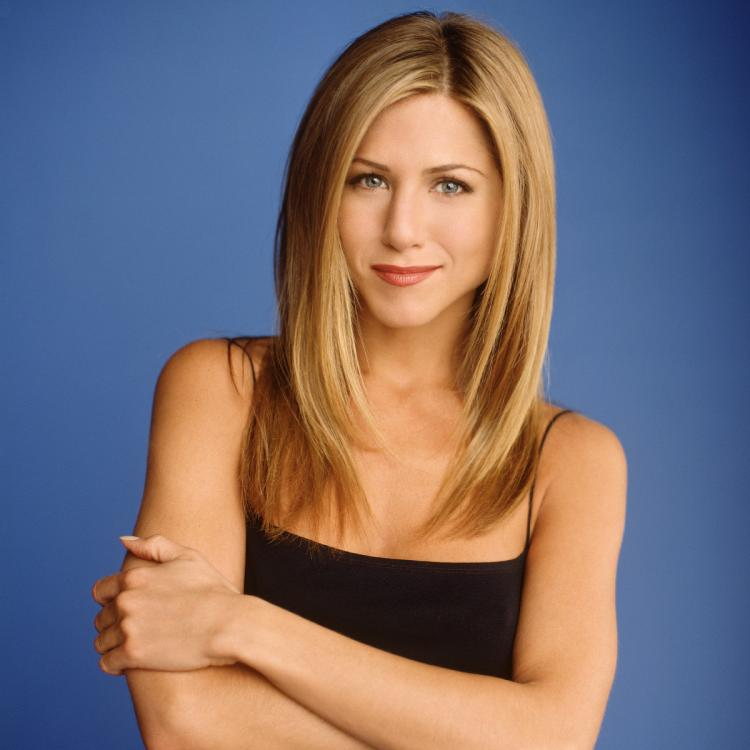

In [887]:
sample = random.choice(cc100k)
print(sample['caption'])
IPython.display.Image(sample['image'], width=300)

In [888]:
image = test_transform(Image.open(sample['image']).convert('RGB'))
view_image = view_transform(Image.open(sample['image']).convert('RGB'))

In [889]:
caption = pre_caption(sample['caption'], 30)
caption

'the cost of the lipstick is going to make you fall off the chair because well we can all wear the shade which person used to wear'

In [890]:
image = image.to(device)

In [891]:
text = tokenizer(caption, padding='longest', truncation=True, max_length=25, return_tensors="pt").to(device)

In [892]:
image_embeds = model.visual_encoder(image.unsqueeze(0)).squeeze()
image_embeds = F.normalize(image_embeds, dim=1)
image_embeds.shape

torch.Size([257, 768])

In [893]:
def is_noun(word):
    try:
        return wn.synsets(word)[0].pos() == 'n'
    except:
        return False
    
def is_adj(word):
    try:
        return wn.synsets(word)[0].pos() == 'a'
    except:
        return False

In [894]:
stopwords = [
    'ring', 'line', 'lines', 'bang', 'west', 'a', 'before', 'there', 'very', 'features',
    'high', 'work', 'works', 'feature', 'study', 'form', 'as', 'period', 'title', 'units', 'name', 'world',
    'project', 'unit', 'ringend', 'element', 'park', 'open'
]

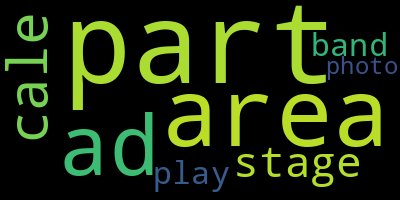

In [895]:
cloud = WordCloud(stopwords=stopwords)
bag_of_words = []
all_words = []
for vit_word in image_embeds:
    sims = vit_word @ word_embeddings.T
    closest_lang_embeds = sims.topk(1).indices
    closest_words = tokenizer.decode(list(closest_lang_embeds.cpu().numpy())).split()
    all_words.append(closest_words[0])
    closest_words = [_ for _ in closest_words if nlp(_)[0].pos_ in ( 'NOUN')]
    bag_of_words.extend(closest_words)
transforms.ToPILImage()(cloud.generate(' '.join(bag_of_words)).to_array())

In [916]:
cut_up = view_image.unfold(1, 16, 16).permute(2,0,3,1)
cut_up.shape

torch.Size([256, 3, 16, 16])

In [901]:
grid = torchvision.utils.make_grid(cut_up, nrow=16).cpu()
sections = []
for idx, square in enumerate(cut_up):
    pil_im = resize(to_pil_image(square), 48)
    draw = ImageDraw.Draw(pil_im)
    draw.text((7, 7), all_words[idx])
    back_to_tensor = to_tensor(pil_im)
    sections.append(back_to_tensor)

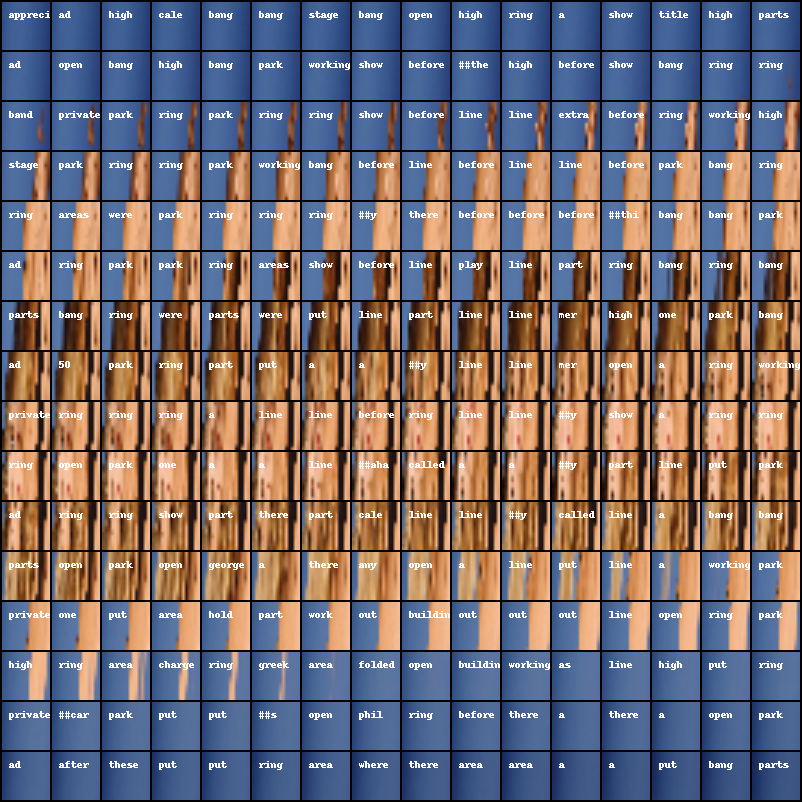

In [902]:
to_pil_image(torchvision.utils.make_grid(sections, nrow=16))

In [801]:
1024 ** 0.5

32.0

In [903]:
to_pil_image(view_image.unfold(1, 16, 16).permute(2,0,3,1))

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.